# Task 4: Forecasting Financial Inclusion in Ethiopia (2025–2027)

## Objective
Forecast:
1. **Account Ownership (Access)** – % of adults with an account
2. **Digital Payment Usage (Usage)** – % of adults using digital payments

Approach:
- Trend-based forecasting (given sparse data)
- Event-informed adjustments
- Scenario analysis (Optimistic, Base, Pessimistic)

Data source:
- Enriched dataset from Tasks 1–3


# Imports & configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True


# Load enriched dataset

In [2]:
DATA_PATH = "../data/processed/enriched_dataset.xlsx"

data = pd.read_excel(DATA_PATH, sheet_name="data")

print("Dataset shape:", data.shape)
data.head()


Dataset shape: (61, 35)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,event_date
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Baseline year,NaN,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN


# Filter target indicators

In [3]:
access = data[
    (data["record_type"] == "observation") &
    (data["indicator_code"] == "ACC_OWNERSHIP")
].copy()

usage = data[
    (data["record_type"] == "observation") &
    (data["indicator_code"].isin([
        "USG_P2P_COUNT",
        "USG_TELEBIRR_USERS",
        "USG_MPESA_USERS"
    ]))
].copy()


# Prepare Access time series

In [4]:
access["year"] = pd.to_datetime(access["observation_date"]).dt.year

access_ts = (
    access.groupby("year")["value_numeric"]
    .mean()
    .reset_index()
    .sort_values("year")
)

access_ts


,year,value_numeric
0,2014,22.0
1,2015,28.5
2,2016,32.0
3,2017,35.0
4,2018,39.0
5,2019,41.0
6,2020,43.5
7,2021,46.0
8,2022,47.0
9,2023,48.0


# Fit baseline trend (linear regression)

In [5]:
x = access_ts["year"].values
y = access_ts["value_numeric"].values

coef = np.polyfit(x, y, 1)   # slope + intercept
trend_fn = np.poly1d(coef)

print("Trend equation:")
print(trend_fn)


Trend equation:
 
2.586 x - 5183


# Forecast baseline (2025–2027)

In [6]:
forecast_years = np.array([2025, 2026, 2027])
baseline_access = trend_fn(forecast_years)

baseline_access


array([54.7       , 57.28636364, 59.87272727])

# Build scenario adjustments (event-informed)

In [7]:
scenario_adjustments = {
    "pessimistic": -2.0,   # inflation, affordability issues
    "base": 0.0,           # expected continuation
    "optimistic": 3.0      # strong mobile + infrastructure push
}

forecast_access = pd.DataFrame({
    "year": forecast_years,
    "pessimistic": baseline_access + scenario_adjustments["pessimistic"],
    "base": baseline_access + scenario_adjustments["base"],
    "optimistic": baseline_access + scenario_adjustments["optimistic"]
})

forecast_access


,year,pessimistic,base,optimistic
0,2025,52.700000,54.700000,57.700000
1,2026,55.286364,57.286364,60.286364
2,2027,57.872727,59.872727,62.872727


# Visualize Access forecast

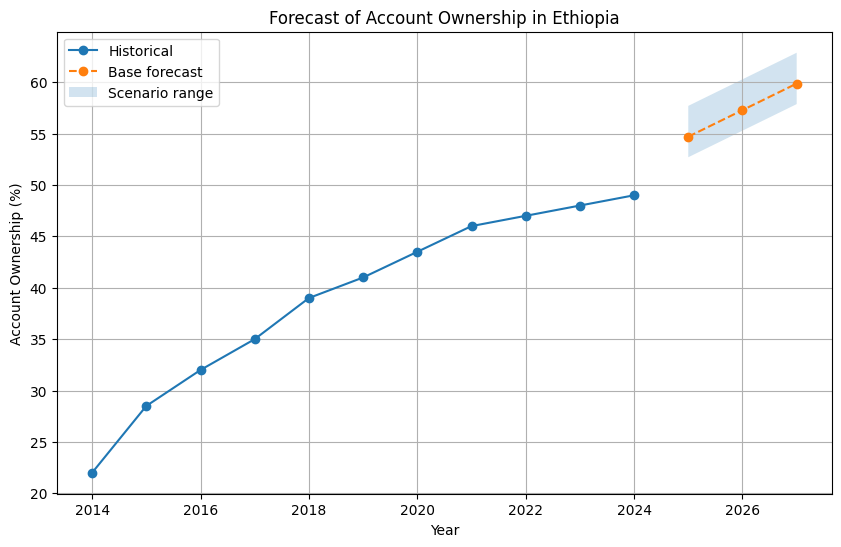

In [8]:
plt.plot(access_ts["year"], access_ts["value_numeric"], 
         marker="o", label="Historical")

plt.plot(forecast_access["year"], forecast_access["base"], 
         marker="o", linestyle="--", label="Base forecast")

plt.fill_between(
    forecast_access["year"],
    forecast_access["pessimistic"],
    forecast_access["optimistic"],
    alpha=0.2,
    label="Scenario range"
)

plt.title("Forecast of Account Ownership in Ethiopia")
plt.xlabel("Year")
plt.ylabel("Account Ownership (%)")
plt.legend()
plt.show()


# Digital payment usage proxy (simplified)

In [9]:
usage["year"] = pd.to_datetime(usage["observation_date"]).dt.year

usage_ts = (
    usage.groupby("year")["value_numeric"]
    .mean()
    .reset_index()
    .sort_values("year")
)

usage_ts


,year,value_numeric
0,2024,30250000.0
1,2025,91570000.0


# Trend + forecast for Usage

In [10]:
x_u = usage_ts["year"].values
y_u = usage_ts["value_numeric"].values

coef_u = np.polyfit(x_u, y_u, 1)
usage_trend = np.poly1d(coef_u)

baseline_usage = usage_trend(forecast_years)

forecast_usage = pd.DataFrame({
    "year": forecast_years,
    "pessimistic": baseline_usage - 3,
    "base": baseline_usage,
    "optimistic": baseline_usage + 5
})

forecast_usage


,year,pessimistic,base,optimistic
0,2025,9.157000e+07,9.157000e+07,9.157000e+07
1,2026,1.528900e+08,1.528900e+08,1.528900e+08
2,2027,2.142100e+08,2.142100e+08,2.142100e+08


In [11]:
OUTPUT_DIR = Path("../reports")
OUTPUT_DIR.mkdir(exist_ok=True)

forecast_access.to_csv(OUTPUT_DIR / "task4_access_forecast.csv", index=False)
forecast_usage.to_csv(OUTPUT_DIR / "task4_usage_forecast.csv", index=False)

print("✓ Forecast tables saved")


✓ Forecast tables saved
